In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import os
import numpy as np
import pandas as pd
from PIL import Image
import time

In [52]:
filenames = glob('IR_images/*.jpg')
filenames.sort(key=lambda filename: os.stat(filename).st_mtime)
file_sizes = [os.path.getsize(filename) for filename in filenames]

In [91]:
if os.path.isfile('IR_is_open.csv'):
    df = pd.read_csv('IR_is_open.csv', index_col=0)
else:
    df = pd.DataFrame(columns=['file_size', 'is_open_guess', 'is_open_human', 'is_open'])
    
for filename, file_size in zip(filenames, file_sizes):
    df.loc[filename, 'file_size'] = int(file_size)

df.is_open_guess = (df.file_size >= 18000).astype(int)

df.is_open = df.is_open_human
index = df.is_open.isnull()
df.loc[ index, 'is_open'] = df.loc[ index, 'is_open_guess']

df.to_csv('IR_is_open.csv')

In [83]:
df.groupby('is_open').count()[['file_size']].rename(columns={'file_size': 'count'})

,count
is_open,
0.0,155
1.0,184


In [84]:
df.groupby('is_open_guess').count()[['file_size']].rename(columns={'file_size': 'count'})

,count
is_open_guess,
0,233
1,106


In [67]:
from PIL import Image, ImageOps

In [72]:
filenames = df.index.values
sample_size = len(filenames)
cut_point = int(sample_size * 0.7)
t1 = time.time()
images = [np.reshape(np.asarray(Image.open(filename)), (-1)) for filename in filenames]
t2 = time.time()
print (t2-t1),'(',(t2-t1)/sample_size,')'

5.09812617302 ( 0.0150387202744 )


In [89]:
print "Training set"
df.iloc[0:cut_point].groupby('is_open').count()[['file_size']].rename(columns={'file_size': 'count'})

Training set


,count
is_open,
0.0,101
1.0,136


In [90]:
print "Test set"
df.iloc[cut_point:-1].groupby('is_open').count()[['file_size']].rename(columns={'file_size': 'count'})

Test set


,count
is_open,
0.0,53
1.0,48


# PCA does not separate the classes ..

 24.0098199844 ( 0.0708254276827 )


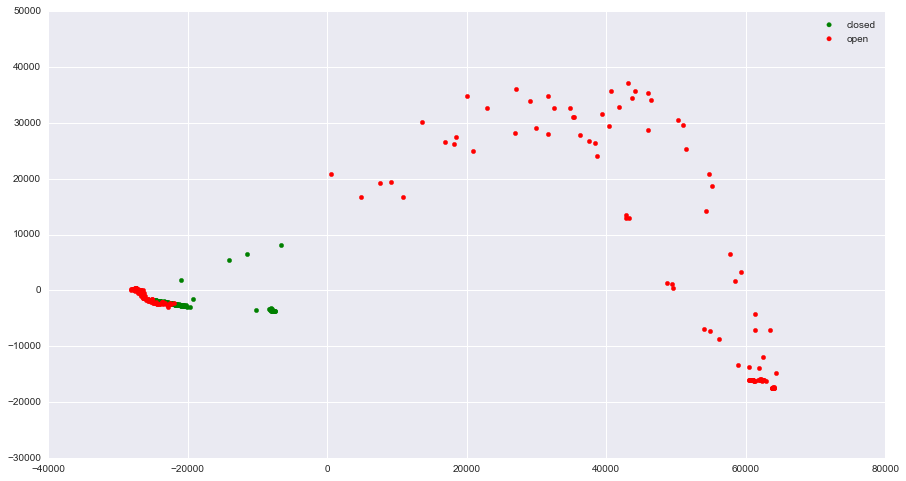

In [71]:
from sklearn.decomposition import PCA
t1 = time.time()
pca = PCA(n_components=2)
pca.fit(images)
vectors = pd.DataFrame(pca.transform(images))
t2 = time.time()
print (t2-t1),'(',(t2-t1)/len(filenames),')'

plt.figure(figsize=(15,8))
vectors_closed = vectors[ (df.is_open == 0).values ]
vectors_open = vectors[ (df.is_open == 1).values ]
plt.scatter(x=vectors_closed[0], y=vectors_closed[1], color='green', label='closed')
plt.scatter(x=vectors_open[0], y=vectors_open[1], color='red', label='open')
plt.legend()
plt.show()

25.1488599777 ( 0.0741854276629 )


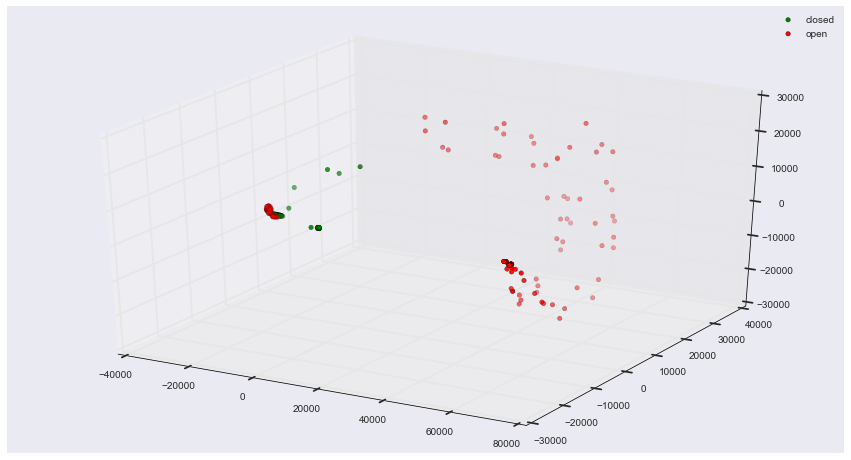

In [73]:
from sklearn.decomposition import PCA
t1 = time.time()
pca = PCA(n_components=3)
pca.fit(images)
vectors = pd.DataFrame(pca.transform(images))
t2 = time.time()
print (t2-t1),'(',(t2-t1)/sample_size,')'

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')
vectors_closed = vectors[ (df.is_open == 0).values ]
vectors_open = vectors[ (df.is_open == 1).values ]
ax.scatter(vectors_closed[0], vectors_closed[1], vectors_closed[2], c='green', label='closed')
ax.scatter(vectors_open[0], vectors_open[1],  vectors_open[2], c='red', label='open')
ax.legend()
plt.show()

In [74]:
X = vectors
y = df.is_open
X_train = X[0:cut_point]
X_test = X[cut_point:-1]
y_train = y[0:cut_point]
y_test = y[cut_point:-1]

## ... and classification on low-dimension PCA does not work at all

27.9962038994 ( 0.0825846722696 )


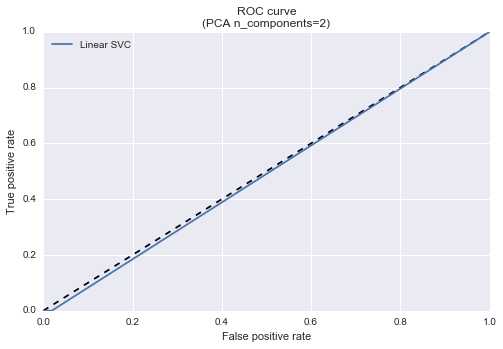

27.7339458466 ( 0.0818110496949 )


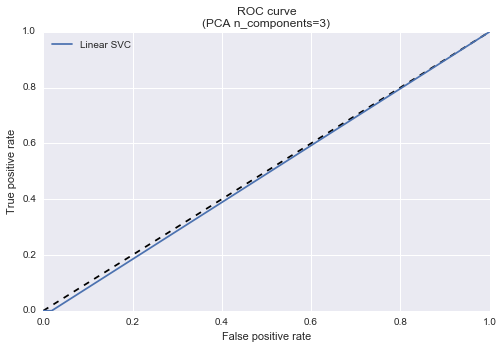

29.5663661957 ( 0.0872164194563 )


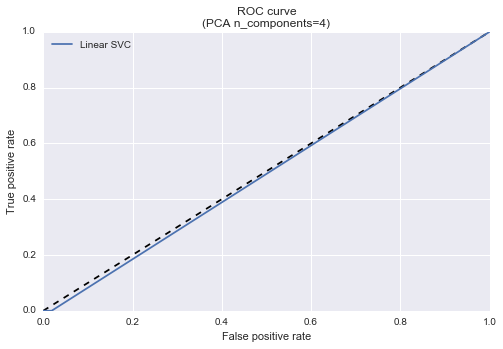

24.614713192 ( 0.0726097734277 )


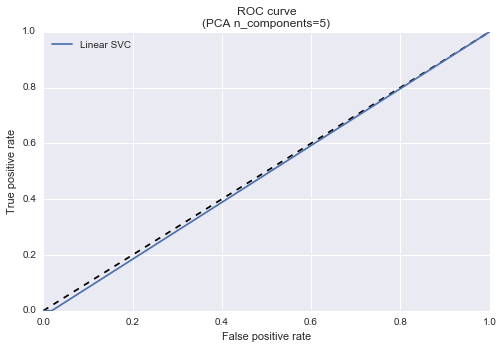

24.1735639572 ( 0.0713084482514 )


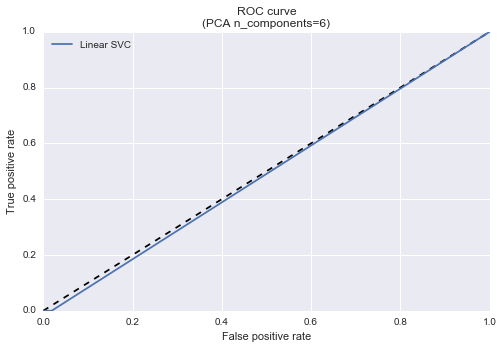

25.058879137 ( 0.0739199974544 )


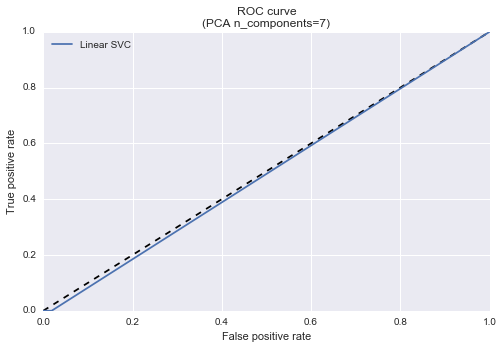

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn import svm

for n_components in [2,3,4,5,6,7]:
    from sklearn.decomposition import PCA
    t1 = time.time()
    pca = PCA(n_components=n_components)
    pca.fit(images)
    vectors = pd.DataFrame(pca.transform(images))
    t2 = time.time()
    print (t2-t1),'(',(t2-t1)/sample_size,')'

    clf = svm.SVC(probability=True)
    clf.fit(X_train, y_train)  
    y_pred_rt = clf.predict_proba(X_test)[:, 1]
    fpr_rt_lsvc, tpr_rt_lsvc, _ = roc_curve(y_test, y_pred_rt)

    plt.figure(1, figsize=(8,5))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rt_lsvc, tpr_rt_lsvc, label='Linear SVC')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve\n(PCA n_components='+str(n_components)+')')
    plt.legend(loc='best')
    plt.show()



In [80]:
# Training on the raw image data ...

In [78]:
X = images
y = df.is_open
X_train = X[0:cut_point]
X_test = X[cut_point:-1]
y_train = y[0:cut_point]
y_test = y[cut_point:-1]

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# clf = RandomForestClassifier(n_estimators=10,max_depth=2, random_state=0)
# clf = GaussianNB()
# clf = svm.SVC(probability=False)
clf = LogisticRegression()
# clf = svm.SVC(kernel='rbf', gamma=0.7)

# clf = svm.LinearSVC()
# clf = DecisionTreeClassifier()
# clf = LinearDiscriminantAnalysis()

# clf = KNeighborsClassifier(n_neighbors = 2)
# clf = AdaBoostClassifier()

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
# clf = Pipeline([('polynomial', PolynomialFeatures(2)),
#                 ('classify', clf)])
clf.fit(X_train, y_train)  

from sklearn.metrics import confusion_matrix
y_pred = clf.predict(X_test)
print confusion_matrix(y_test, y_pred)

y_pred = clf.predict(X)
print confusion_matrix(y, y_pred)

[[53  0]
 [ 1 47]]
[[155   0]
 [  1 183]]


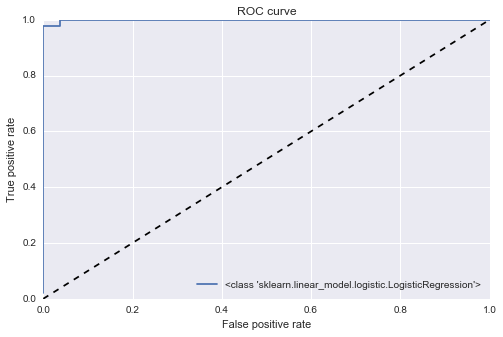

In [82]:
y_pred_rt = clf.predict_proba(X_test)[:, 1]
fpr_rt_lsvc, tpr_rt_lsvc, _ = roc_curve(y_test, y_pred_rt)

plt.figure(1, figsize=(8,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lsvc, tpr_rt_lsvc, label=str(type(clf)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


# Steps to world domination (err.. rollout):

- Create a github project
- Install Python 2.7 on the raspberrypi and figure out, document, and install all the dependencies
- Persist the classifier (pickle? better way?)
- Create a script to watch for new image files
- Classify new image files & append results to a classification csv (clipped to last N classifications - 1000?)
- Add sms-notification mechanism to the script with incremental back-off (0 minutes, 5, 10, 20, 40, 80, ...)